# EDA For Kaggle Competition 

Following the excellent kernal on kaggel (https://www.kaggle.com/sudalairajkumar/simple-exploration-notebook-sberbank) to understand the data better, to explore further and give us a path start. To start out this is going to be a spot on copy of the linked project. 

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import model_selection, preprocessing
import xgboost as xgb
color = sns.color_palette()

%matplotlib inline

pd.options.mode.chained_assignment = None  # default='warn'
pd.set_option('display.max_columns', 500)

In [16]:
import scipy as sp

In [17]:
import sklearn
print sklearn.__version__

0.18.1


Importing the train file and understanding the data. 

In [18]:
train_df =  pd.read_csv("train.csv")
train_df.shape

(30471, 292)

The train data has 30471 rows and 292 columns. That's a lot of features! 

In [19]:
train_df.head()

,id,timestamp,full_sq,life_sq,floor,max_floor,material,build_year,num_room,kitch_sq,state,product_type,sub_area,area_m,raion_popul,green_zone_part,indust_part,children_preschool,preschool_quota,preschool_education_centers_raion,children_school,school_quota,school_education_centers_raion,school_education_centers_top_20_raion,hospital_beds_raion,healthcare_centers_raion,university_top_20_raion,sport_objects_raion,additional_education_raion,culture_objects_top_25,culture_objects_top_25_raion,shopping_centers_raion,office_raion,thermal_power_plant_raion,incineration_raion,oil_chemistry_raion,radiation_raion,railroad_terminal_raion,big_market_raion,nuclear_reactor_raion,detention_facility_raion,full_all,male_f,female_f,young_all,young_male,young_female,work_all,work_male,work_female,ekder_all,ekder_male,ekder_female,0_6_all,0_6_male,0_6_female,7_14_all,7_14_male,7_14_female,0_17_all,0_17_male,0_17_female,16_29_all,16_29_male,16_29_female,0_13_all,0_13_male,0_13_female,raion_build_count_with_material_info,build_count_block,build_count_wood,build_count_frame,build_count_brick,build_count_monolith,build_count_panel,build_count_foam,build_count_slag,build_count_mix,raion_build_count_with_builddate_info,build_count_before_1920,build_count_1921-1945,build_count_1946-1970,build_count_1971-1995,build_count_after_1995,ID_metro,metro_min_avto,metro_km_avto,metro_min_walk,metro_km_walk,kindergarten_km,school_km,park_km,green_zone_km,industrial_km,water_treatment_km,cemetery_km,incineration_km,railroad_station_walk_km,railroad_station_walk_min,ID_railroad_station_walk,railroad_station_avto_km,railroad_station_avto_min,ID_railroad_station_avto,public_transport_station_km,public_transport_station_min_walk,water_km,water_1line,mkad_km,ttk_km,sadovoe_km,bulvar_ring_km,kremlin_km,big_road1_km,ID_big_road1,big_road1_1line,big_road2_km,ID_big_road2,railroad_km,railroad_1line,zd_vokzaly_avto_km,ID_railroad_terminal,bus_terminal_avto_km,ID_bus_terminal,oil_chemistry_km,nuclear_reactor_km,radiation_km,power_transmission_line_km,thermal_power_plant_km,ts_km,big_market_km,market_shop_km,fitness_km,swim_pool_km,ice_rink_km,stadium_km,basketball_km,hospice_morgue_km,detention_facility_km,public_healthcare_km,university_km,workplaces_km,shopping_centers_km,office_km,additional_education_km,preschool_km,big_church_km,church_synagogue_km,mosque_km,theater_km,museum_km,exhibition_km,catering_km,ecology,green_part_500,prom_part_500,office_count_500,office_sqm_500,trc_count_500,trc_sqm_500,cafe_count_500,cafe_sum_500_min_price_avg,cafe_sum_500_max_price_avg,cafe_avg_price_500,cafe_count_500_na_price,cafe_count_500_price_500,cafe_count_500_price_1000,cafe_count_500_price_1500,cafe_count_500_price_2500,cafe_count_500_price_4000,cafe_count_500_price_high,big_church_count_500,church_count_500,mosque_count_500,leisure_count_500,sport_count_500,market_count_500,green_part_1000,prom_part_1000,office_count_1000,office_sqm_1000,trc_count_1000,trc_sqm_1000,cafe_count_1000,cafe_sum_1000_min_price_avg,cafe_sum_1000_max_price_avg,cafe_avg_price_1000,cafe_count_1000_na_price,cafe_count_1000_price_500,cafe_count_1000_price_1000,cafe_count_1000_price_1500,cafe_count_1000_price_2500,cafe_count_1000_price_4000,cafe_count_1000_price_high,big_church_count_1000,church_count_1000,mosque_count_1000,leisure_count_1000,sport_count_1000,market_count_1000,green_part_1500,prom_part_1500,office_count_1500,office_sqm_1500,trc_count_1500,trc_sqm_1500,cafe_count_1500,cafe_sum_1500_min_price_avg,cafe_sum_1500_max_price_avg,cafe_avg_price_1500,cafe_count_1500_na_price,cafe_count_1500_price_500,cafe_count_1500_price_1000,cafe_count_1500_price_1500,cafe_count_1500_price_2500,cafe_count_1500_price_4000,cafe_count_1500_price_high,big_church_count_1500,church_count_1500,mosque_count_1500,leisure_count_1500,sport_count_1500,market_count_1500,green_part_2000,prom_part_2000,office_count_2000,office_sqm_2000,trc_count_2000,trc_sqm_2000,cafe_count_2000,cafe_sum_2000_min_price_avg,cafe_sum_2000_max_price_av

There are a ton of variables!  Let's look at the target variable first since that is what one should do! 

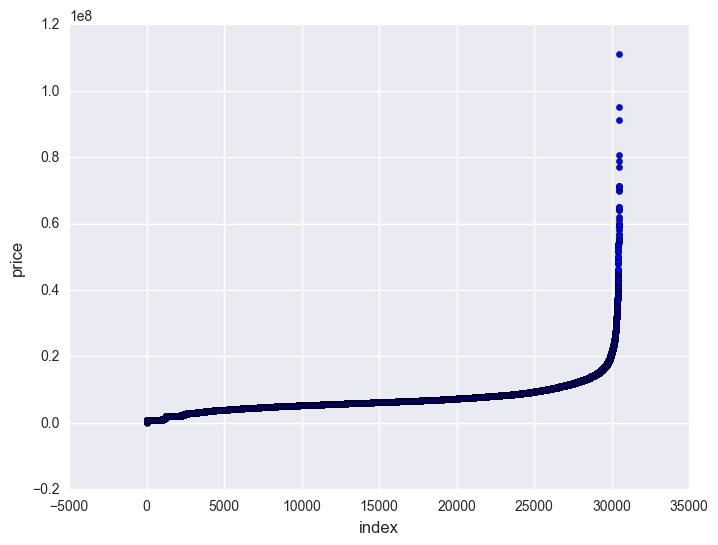

In [20]:
plt.figure(figsize=(8,6))
plt.scatter(range(train_df.shape[0]), np.sort(train_df.price_doc.values))
plt.xlabel('index', fontsize=12)
plt.ylabel('price', fontsize=12)
plt.show()

Let's look at the distribution of the target variable. 

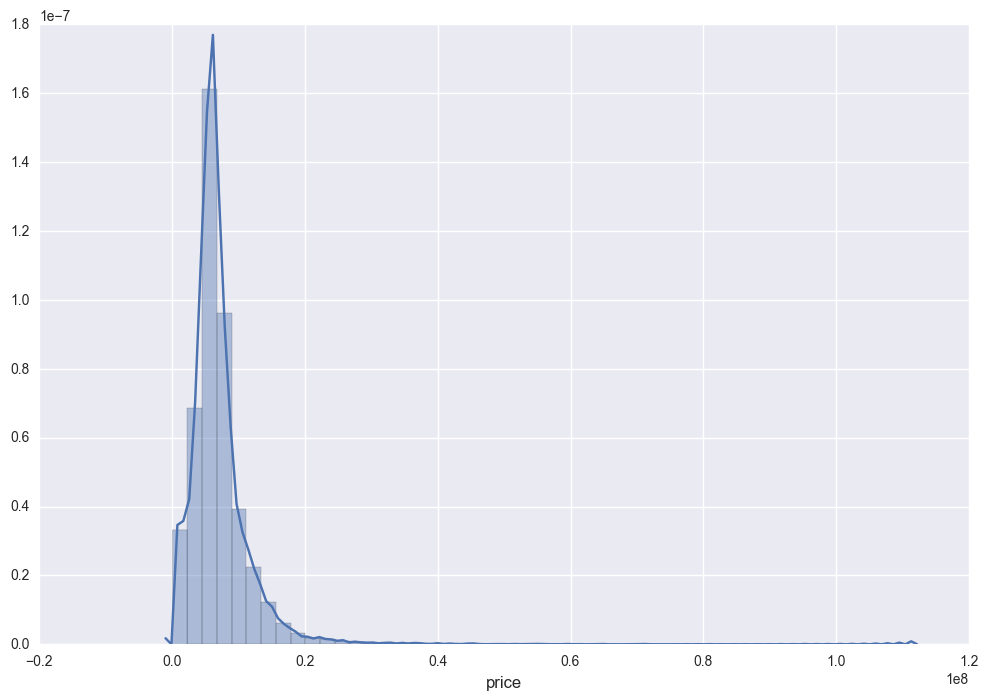

In [21]:
plt.figure(figsize = (12,8))
sns.distplot(train_df.price_doc.values, bins=50, kde = True)

plt.xlabel('price', fontsize = 12)
plt.show()

This is not a very normal distribution. Certainly a very long right tail. Since our metric is Root Mean Square Logarithmic error, let us plot the log of price_doc variable. So let's take the log transform 

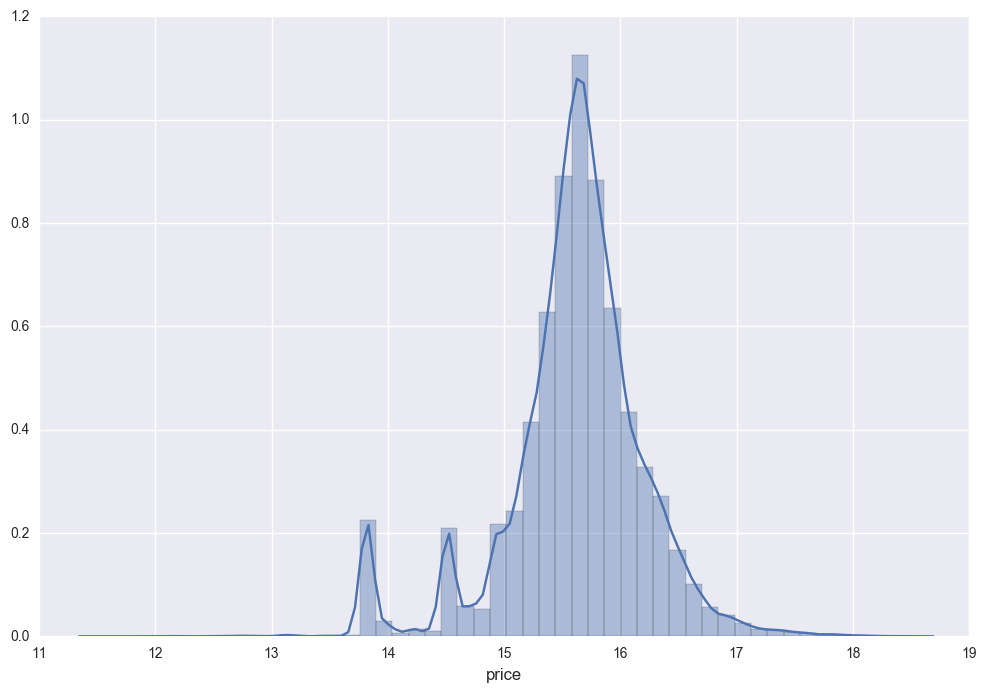

In [22]:
plt.figure(figsize= (12,8))
sns.distplot(np.log(train_df.price_doc.values), bins=50, kde=True)
plt.xlabel('price', fontsize =12)
plt.show()

This is a much better distribution than before. Now let us look at how the median housing price change with time. 

In [23]:
train_df['yearmonth'] = train_df['timestamp'].apply(lambda x: x[:4]+x[5:7])
grouped_df = train_df.groupby('yearmonth')['price_doc'].aggregate(np.median).reset_index()

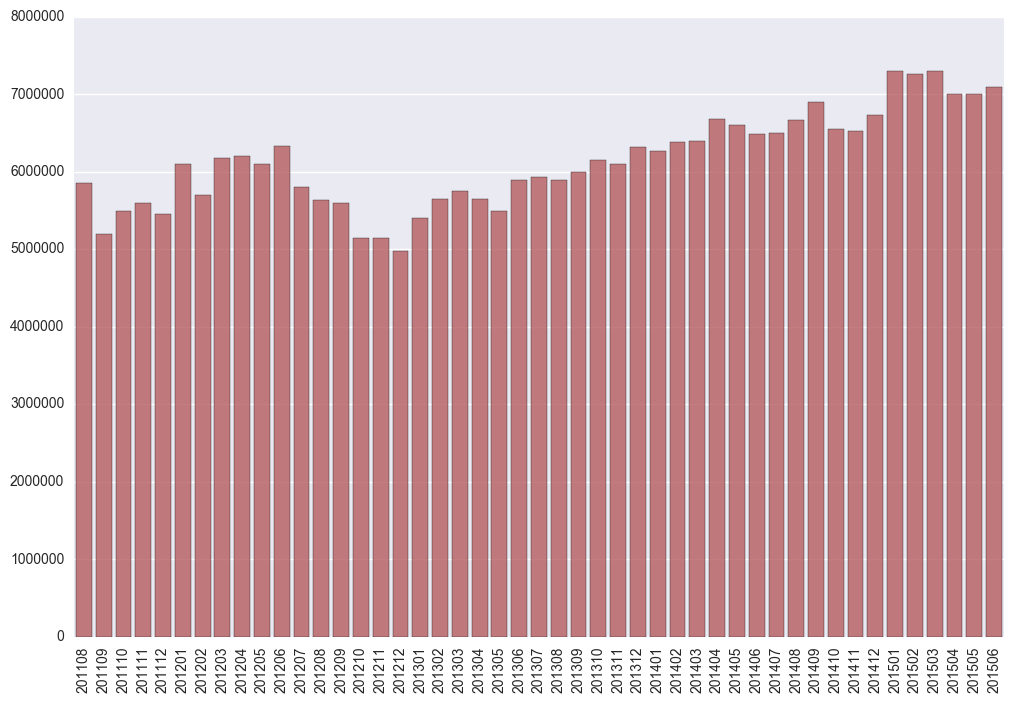

In [24]:
plt.figure(figsize=(12,8))
sns.barplot(grouped_df.yearmonth.values, grouped_df.price_doc.values, alpha=0.8, color=color[2])
plt.xticks(rotation='vertical')
plt.show()

There are some variations in the median price with respect to time. Towards the end, there appears to be some linear increase in the price values. The data time line extends from August 2011 to June 2015. 


Now lets look into some other variable and see what we find. 

In [25]:
train_df = pd.read_csv("train.csv", parse_dates=['timestamp']) 
dtype_df = train_df.dtypes.reset_index()
dtype_df.columns = ["Count", "Column_Type"]
dtype_df.groupby("Column_Type").aggregate('count').reset_index()
# OK this is a cool method to find the number of dtypes in a DF 

,Column_Type,Count
0,int64,157
1,datetime64[ns],1
2,float64,119
3,object,15


So a majority of them are numerical variables with 15 variables and 1 date variable. Lets explore the number of missing values in each column. Note: there are 30471 rows. 

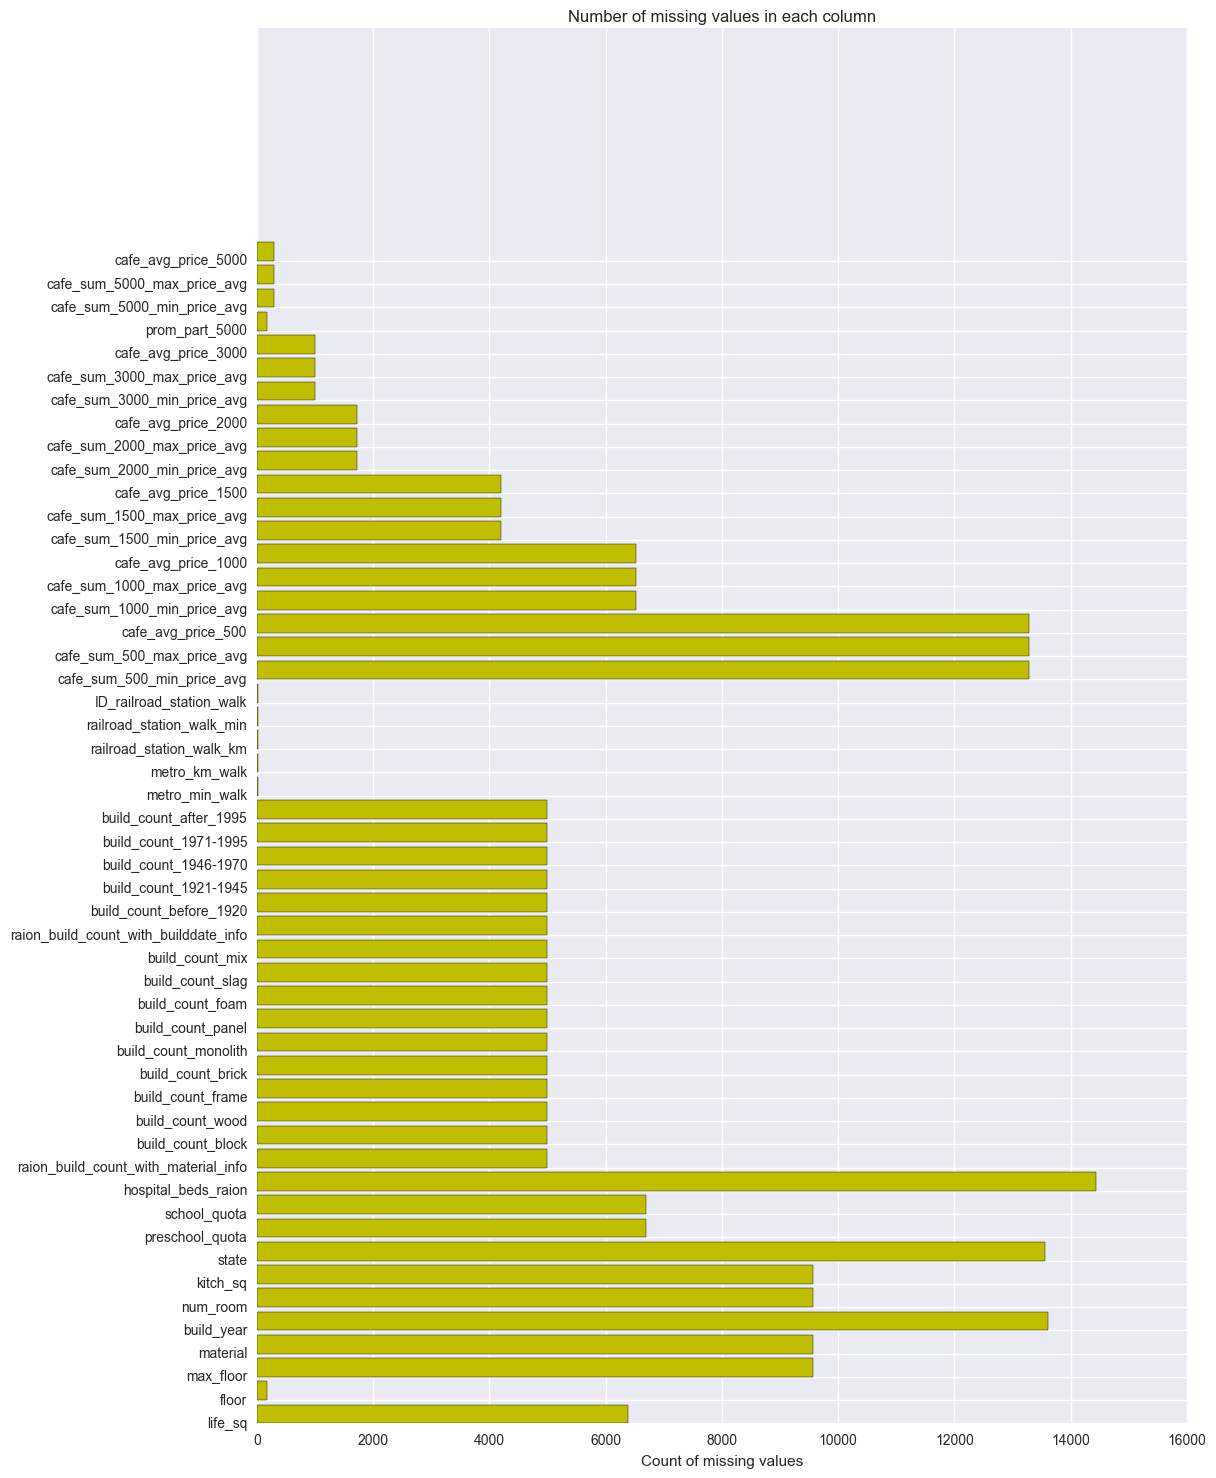

In [26]:
missing_df = train_df.isnull().sum(axis=0).reset_index()
missing_df.columns = ['column_name', 'missing_count']
missing_df = missing_df.ix[missing_df['missing_count'] > 0]
ind = np.arange(missing_df.shape[0])
width =  0.9 
fig, ax = plt.subplots(figsize=(12,18))
rects = ax.barh(ind, missing_df.missing_count.values, color ='y')
ax.set_yticks(ind)
ax.set_yticklabels(missing_df.column_name.values, rotation='horizontal')
ax.set_xlabel("Count of missing values")
ax.set_title("Number of missing values in each column")
plt.show()
# OK this is cool way to display missing values

In [27]:
for f in train_df.columns: 
    if train_df[f].dtype == 'object':
        lbl = preprocessing.LabelEncoder()
        lbl.fit(list(train_df[f].values))
        train_df[f] = lbl.transform(list(train_df[f].values))
train_y = train_df.price_doc.values
train_X = train_df.drop(["id","timestamp","price_doc"], axis = 1)

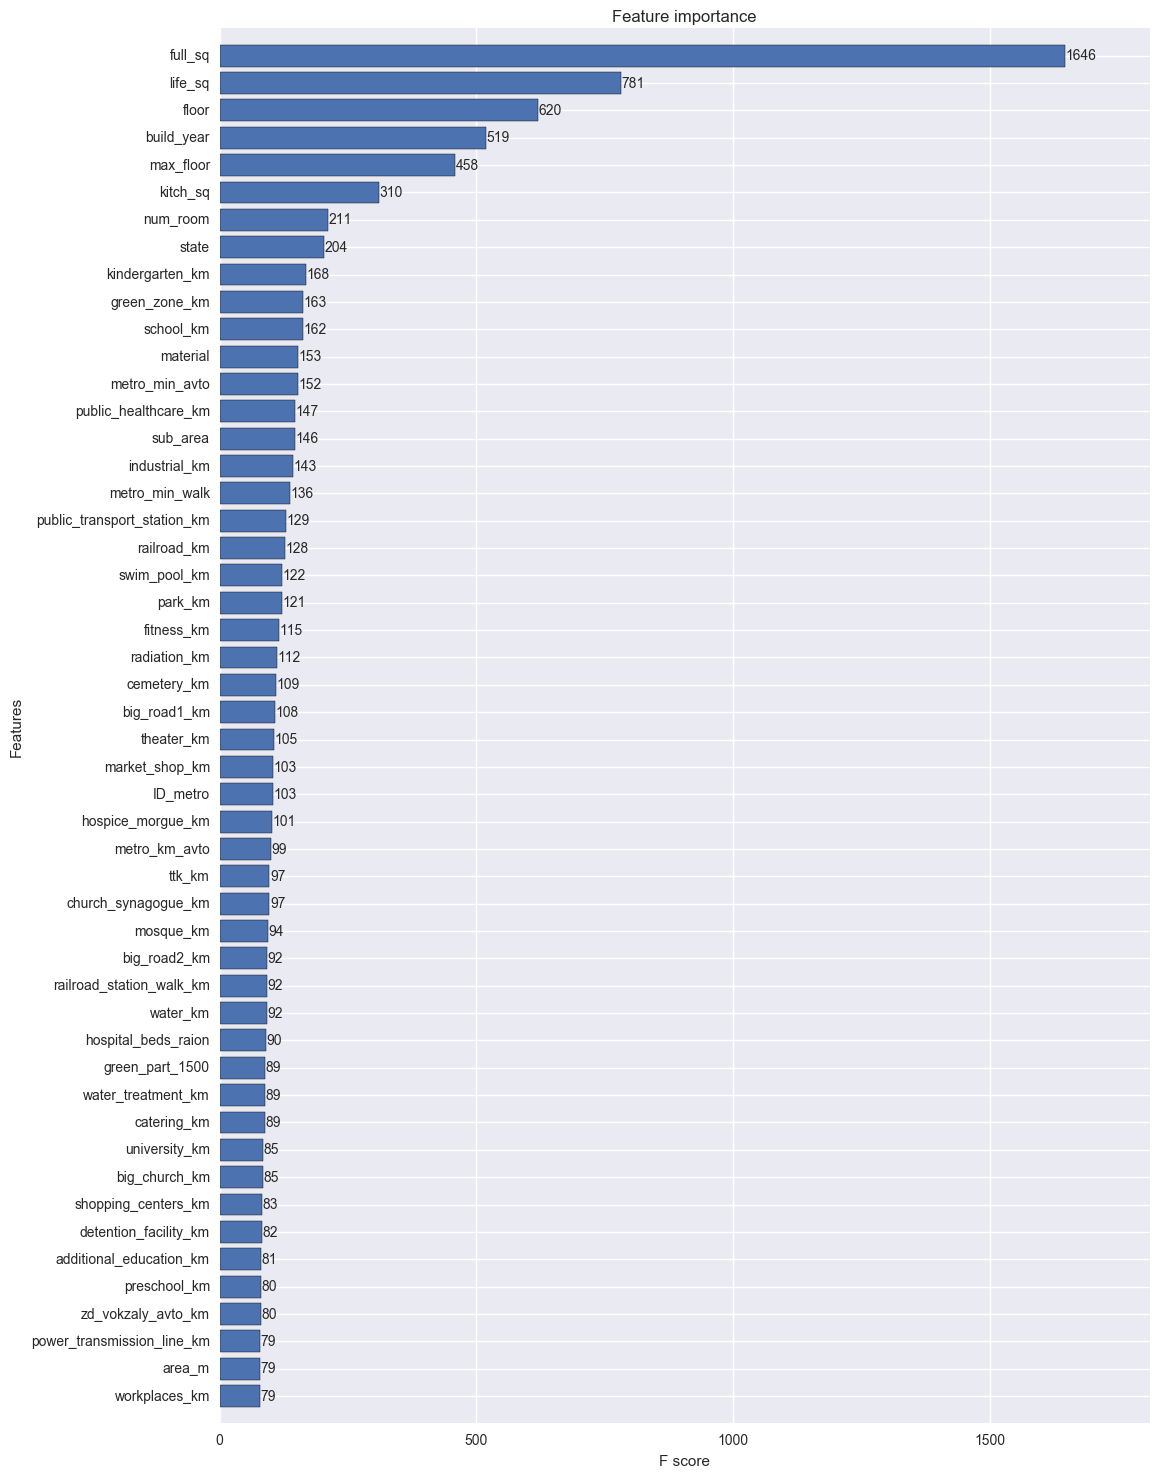

In [28]:
xgb_params = {
    'eta': 0.05,
    'max_depth': 8,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'objective': 'reg:linear',
    'eval_metric': 'rmse',
    'silent': 1
}
dtrain = xgb.DMatrix(train_X, train_y, feature_names=train_X.columns.values)
model = xgb.train(dict(xgb_params, silent=0), dtrain, num_boost_round=100)
# plot the important features #
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(model, max_num_features=50, height=0.8, ax=ax)
plt.show()

The above plot is the F-score (look that up) as a function of the features and tells us the importance of the features. The top 15 features (in order) are: 

1) full_sq: total area in square meters, including loggias, balconies and other non-residential areas

2) life_sq: living area in square meters, excluding loggias, balconies and other non-residential areas

3) floor: for apartments, floor of the building

4) build_year: year built

5) max_floor: number of floors in the building

6) kitch_sq: kitchen area

7) num_room: number of living rooms

8) state: apartment condition

9) kindergarten_km	Distance to kindergarten

10) green_zone_km:	Distance to green zone

11) school_km	Distance to high school 

12) material: wall material

13) metro_min_avto:	Time to subway by car, min.

14) public_healthcare_km	Distance to public healthcare

15) sub_area: name of the district

16) industrial_zone_km	Distance to industrial zone

17) metro_min_walk	Time to metro by foot

18) public_healthcare_km	Distance to public healthcare

19) railroad_km	Distance to the railway / Moscow Central Ring / open areas Underground

20) swim_pool_km	Distance to swimming pool

## Coming Back to look at these variables and To Clean Them
## For now let's move forward with the kernel and LEARN! 


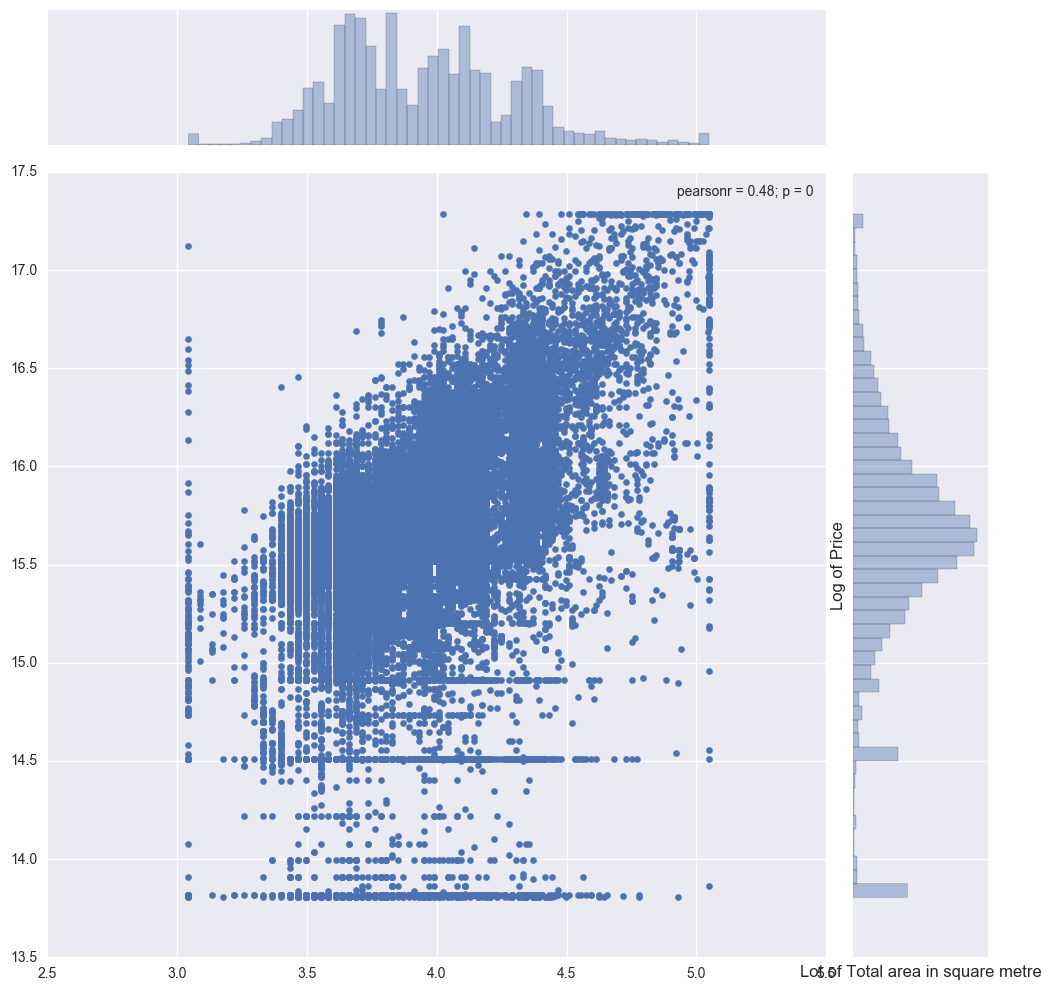

In [29]:
ulimit = np.percentile(train_df.price_doc.values,99.5) # I think is to deal with price outliers
llimit = np.percentile(train_df.price_doc.values,0.5)
train_df['price_doc'].ix[train_df['price_doc']> ulimit] = ulimit
train_df['price_doc'].ix[train_df['price_doc']< llimit] = llimit

col = "full_sq"
ulimit = np.percentile(train_df[col].values, 99.5) # again resetting low and high outliers. 
llimit = np.percentile(train_df[col].values, 0.5)
train_df[col].ix[train_df[col]>ulimit] = ulimit
train_df[col].ix[train_df[col]<llimit] = llimit

plt.figure(figsize=(12,12)) # log1p:  Calculates ``log(1 + x)``.
sns.jointplot(x=np.log1p(train_df.full_sq.values), y=np.log1p(train_df.price_doc.values), size=10)
plt.ylabel('Log of Price', fontsize = 12)
plt.xlabel('Lot of Total area in square metre', fontsize =12) # the log of the area doesn't look gaussian
plt.show()

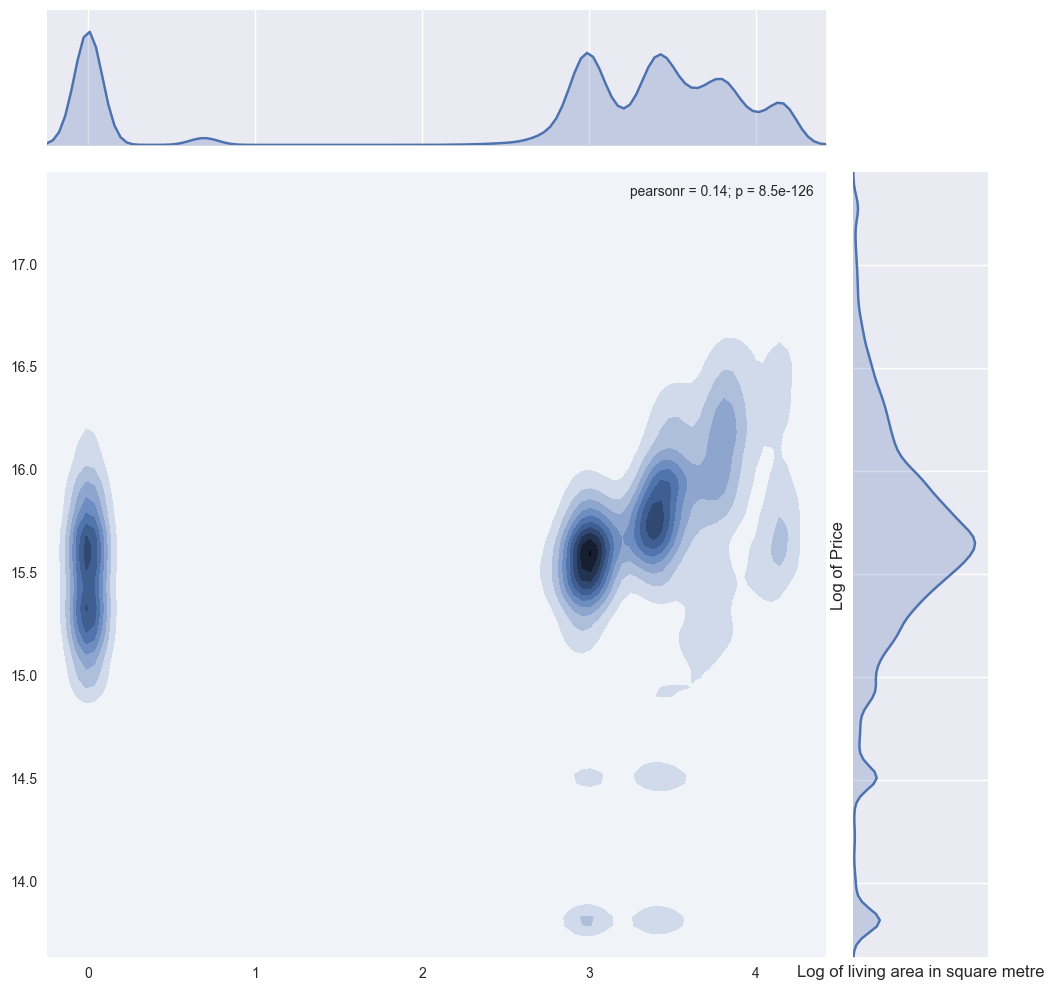

In [30]:
col = "life_sq"
train_df[col].fillna(0,inplace = True)
ulimit = np.percentile(train_df[col].values,95)
llimit = np.percentile(train_df[col].values, 5)
train_df[col].ix[train_df[col] > ulimit] = ulimit
train_df[col].ix[train_df[col] < llimit] = llimit

plt.figure(figsize = (12,12))
sns.jointplot(x=np.log1p(train_df.life_sq.values), y = np.log1p(train_df.price_doc.values), kind='kde', size=10)
plt.ylabel('Log of Price', fontsize = 12)
plt.xlabel('Log of living area in square metre', fontsize=12)
plt.show()

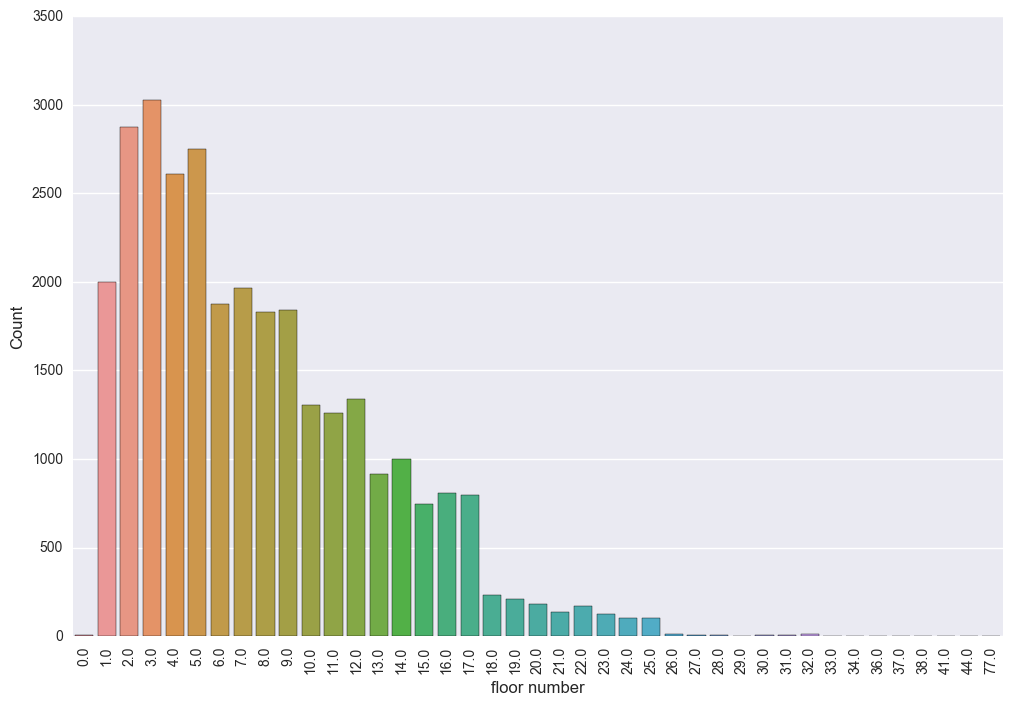

In [31]:
plt.figure(figsize=(12,8))
sns.countplot(x="floor", data=train_df)
plt.ylabel('Count', fontsize=12)
plt.xlabel('floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

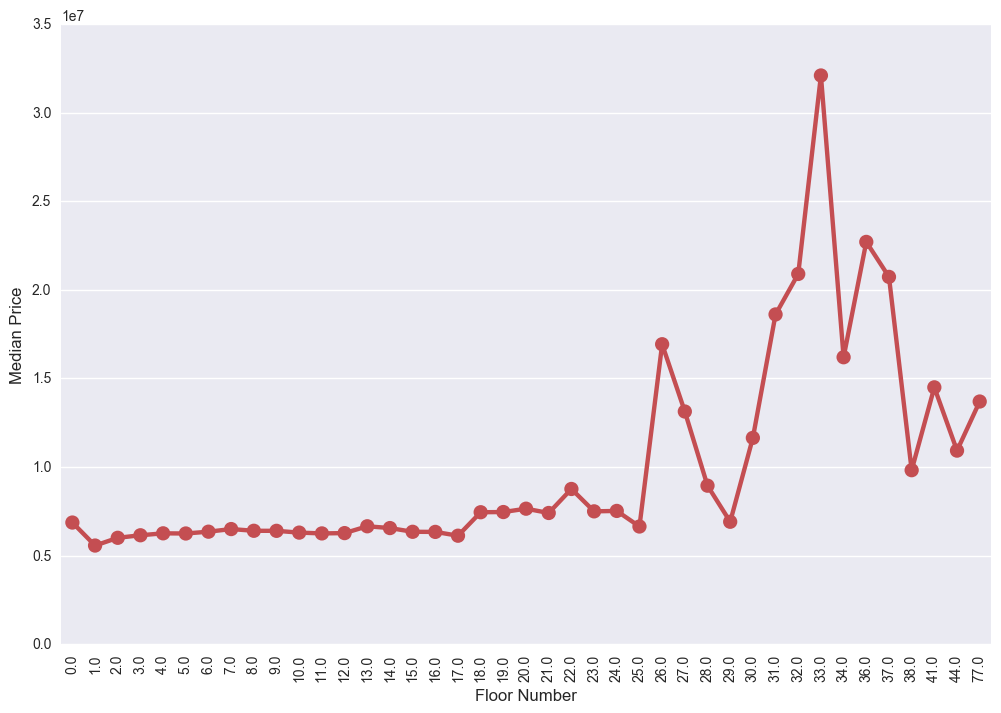

In [32]:
grouped_df = train_df.groupby('floor')['price_doc'].aggregate(np.median).reset_index()
plt.figure(figsize =(12,8))
sns.pointplot(grouped_df.floor.values, grouped_df.price_doc.values, alpha=0.8, color=color[2])
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Floor Number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

This shows an overall increasing trend (individual houses seems to be costlier as well - check price of 0 floor houses). A sudden increase in the house price is also observed at floor 18. The tallest building in Russia is 101 floors!!!

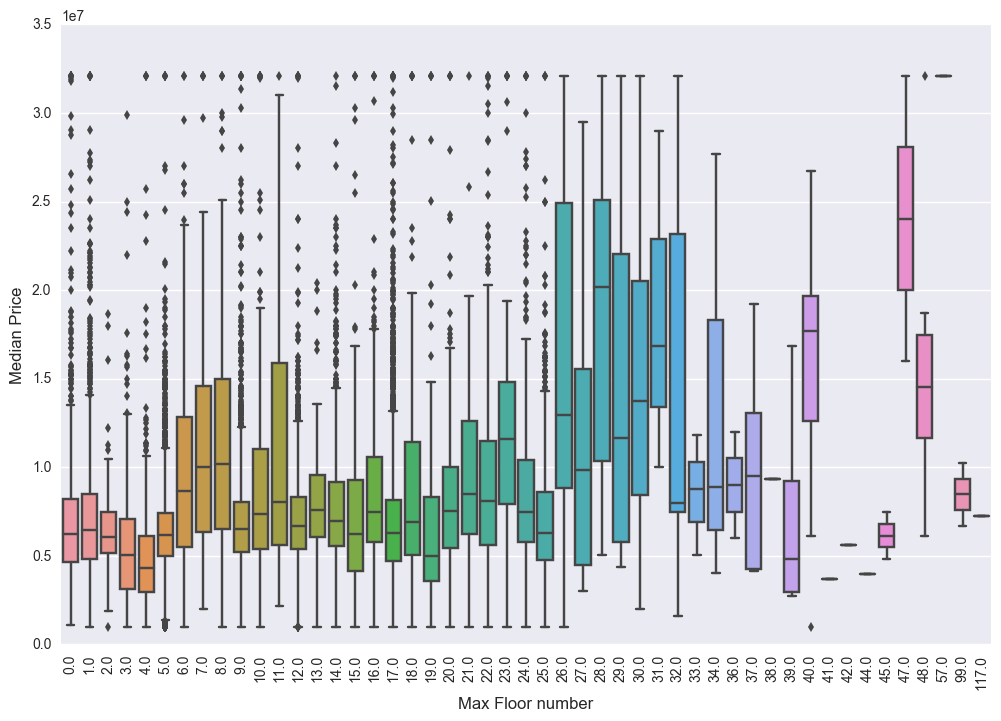

In [33]:
plt.figure(figsize=(12,8))
sns.boxplot(x="max_floor", y="price_doc", data=train_df)
plt.ylabel('Median Price', fontsize=12)
plt.xlabel('Max Floor number', fontsize=12)
plt.xticks(rotation='vertical')
plt.show()

# This Ends the first Kernel. Going on to check out Shu's Data Cleaning 

In [10]:
import pandas as pd
from pandas.io.json import build_table_schema
from pandas.plotting import scatter_matrix
import seaborn as sns
import numpy as np
import scipy as sp
import os
import xgboost as xgb
import visualization as vis
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline

DIR_PATH = './'

ImportError: No module named visualization

In [16]:
train_raw =  pd.read_csv(os.path.join(DIR_PATH,'train.csv'),
                        header='infer',
                        index_col='id',
                        parse_dates=['timestamp'])
test_raw = pd.read_csv(os.path.join(DIR_PATH, 'test.csv'),
                       header='infer',
                       index_col = 'id',
                       parse_dates=['timestamp'])
macro = pd.read_csv(os.path.join(DIR_PATH, 'macro.csv'),
                   header='infer')

# Data Understanding and Data Preparation

In [17]:
train_schema = pd.DataFrame(build_table_schema(train_raw)['fields'])

In [18]:
train_schema.head(10)

,name,type
0,id,integer
1,timestamp,datetime
2,full_sq,integer
3,life_sq,number
4,floor,number
5,max_floor,number
6,material,number
7,build_year,number
8,num_room,number
9,kitch_sq,number


In [19]:
macro_schema = pd.DataFrame(build_table_schema(macro)['fields'])
macro_schema.head() # Note the timestamp here is a string and not a datetime object. This would effect any type of join

,name,type
0,index,integer
1,timestamp,string
2,oil_urals,number
3,gdp_quart,number
4,gdp_quart_growth,number


In [20]:
## start from the top 20 + timestamp features first found from the last kernal
#property_features = ['timestamp', 'full_sq', 'life_sq', 'floor', 
#                     'max_floor', 'material', 'build_year', 'num_room',
#                     'kitch_sq', 'state', 'product_type', 'sub_area', 
#                     'price_doc']

top_features =["timestamp","full_sq","life_sq","floor","build_year","max_floor",
                 "kitch_sq", "num_room", "state", "kindergarten_km", "green_zone_km",
                 "school_km", "metro_min_avto", "public_healthcare_km",
                 "sub_area", "industrial_km", "metro_min_walk", "public_healthcare_km",
                 "railroad_km","swim_pool_km", 'material','price_doc']

train = train_raw[top_features]
test = test_raw[top_features[:-1]]
train.head()

,timestamp,full_sq,life_sq,floor,build_year,max_floor,kitch_sq,num_room,state,kindergarten_km,...,metro_min_avto,public_healthcare_km,sub_area,industrial_km,metro_min_walk,public_healthcare_km,railroad_km,swim_pool_km,material,price_doc
id,,,,,,,,,,,,,,,,,,,,,
1,2011-08-20,43,27.0,4.0,NaN,NaN,NaN,NaN,NaN,0.145700,...,2.590241,0.974743,Bibirevo,1.080934,13.575119,0.974743,1.305159,3.065047,NaN,5850000
2,2011-08-23,34,19.0,3.0,NaN,NaN,NaN,NaN,NaN,0.147754,...,0.936700,1.477723,Nagatinskij Zaton,0.966479,7.620630,1.477723,0.694536,2.000154,NaN,6000000
3,2011-08-27,43,29.0,2.0,NaN,NaN,NaN,NaN,NaN,0.049102,...,2.120999,0.097144,Tekstil'shhiki,0.939275,17.351515,0.097144,0.700691,1.239304,NaN,5700000
4,2011-09-01,89,50.0,9.0,NaN,NaN,NaN,NaN,NaN,0.179441,...,1.489049,2.163735,Mitino,0.451173,11.565624,2.163735,1.999265,1.950317,NaN,13100000
5,2011-09-05,77,77.0,4.0,NaN,NaN,NaN,NaN,NaN,0.247901,...,1.257186,1.121703,Basmannoe,0.392871,8.266305,1.121703,0.084113,2.544696,NaN,16331452


## Looking at the Target Parameter Distribution

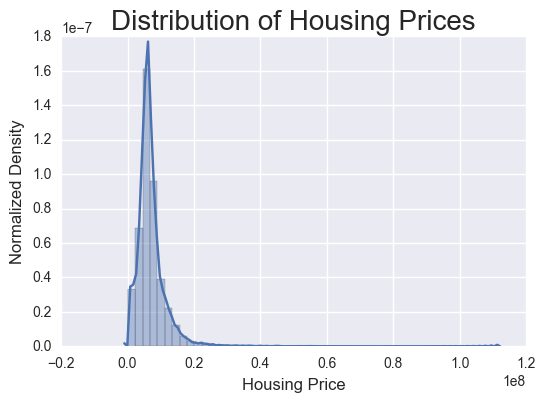

In [21]:
sns.distplot(train.price_doc.values, bins=50, kde = True)
plt.xlabel("Housing Price",fontsize = 12)
plt.title("Distribution of Housing Prices", fontsize = 20)
plt.ylabel("Normalized Density", fontsize = 12)

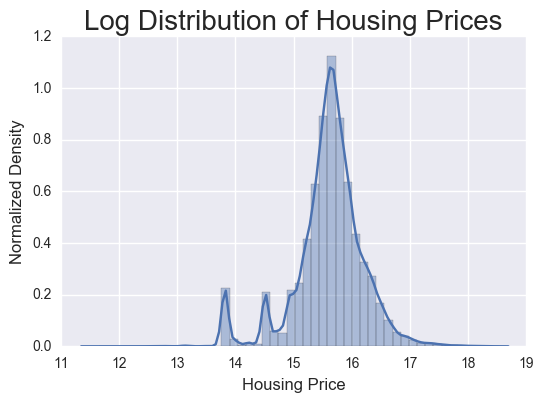

In [22]:
sns.distplot(np.log(train.price_doc.values), bins=50, kde = True)
plt.xlabel("Housing Price",fontsize = 12)
plt.title("Log Distribution of Housing Prices", fontsize = 20)
plt.ylabel("Normalized Density", fontsize = 12)

In [23]:
train[['price_doc','material']].head()

,price_doc,material
id,,
1,5850000,NaN
2,6000000,NaN
3,5700000,NaN
4,13100000,NaN
5,16331452,NaN


In [24]:
sns.boxplot(x='material', y='price_doc', data=train, palette='Set3')

TypeError: cannot label index with a null key

In [25]:
print(train['material'].value_counts(dropna=False))
print(test['material'].value_counts(dropna=False))

 1.0    14197
NaN      9572
 2.0     2993
 5.0     1561
 4.0     1344
 6.0      803
 3.0        1
Name: material, dtype: int64
1    5241
2     958
4     619
5     487
6     356
3       1
Name: material, dtype: int64
